<a href="https://colab.research.google.com/github/Shuvo3128/AI-Engineer-Level-1-Technical-Assessment/blob/main/RAG_System_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain faiss-cpu sentence-transformers openai
!pip install -q unstructured pdfminer.six
!pip install -q pymupdf
!pip install -U langchain-community
!pip install pytesseract pillow
!sudo apt install tesseract-ocr tesseract-ocr-ben

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your "HSC26-Bangla1st-Paper.pdf"

Saving HSC26-Bangla1st-Paper.pdf to HSC26-Bangla1st-Paper.pdf


In [ ]:
import fitz
import pytesseract
from PIL import Image
import re
import unicodedata
from rapidfuzz import fuzz, process

#1.Extract OCR Text from PDF Pages
def extract_ocr_text(pdf_path, start_page, end_page):
    doc = fitz.open(pdf_path)
    extracted_text = []
    for i in range(start_page - 1, end_page):
        pix = doc[i].get_pixmap(dpi=300)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        text = pytesseract.image_to_string(img, lang="ben")
        extracted_text.append(text)
    return "\n".join(extracted_text)

#2.Normalize Unicode
def normalize_unicode(text):
    return unicodedata.normalize("NFKC", text)

def fix_common_errors(text):
    corrections = {
        'আলা ব্যাচ': 'অনলাইন ব্যাচ',
        'আলা': 'অনলাইন',
        'প্রশ্ব': 'প্রশ্ন',
        ' োোলক': 'লোক',
        'ি াি কািণ': 'কি কারণে',
        'রব্চক্ষণতা': 'বুদ্ধিমত্তা',
        'কূট বুরি': 'কূটবুদ্ধি',
        'উকদযাগ': 'উদ্যোগ',
        'রনকলও': 'নিলেও',
        'রনক': 'না',
        'বা়োবার়ে': 'বাধাব্যর্থ',
        'কবাি কািকণ': 'কোন কারণে',
        'রপতা': 'হয়তো',
        'তাি': 'তবে',
        'হকলও': 'হলেও',
        'কতবা': 'কিন্তু',
        'কনযাি': 'কন্যা',
        'রসবান্ত': 'নিজের',
        'রিকলন': 'লালন',
        'পরিবাকিি': 'পরিবারের',
        'রিজক্ষত': 'মেধাবী',
        'উিি': 'উত্তর',
        'পক়ে': 'পড়ে',
        'প্রকেি': 'প্রশ্নের',
        'দেিতাি': 'দ্বিতীয়',
        'এলজন্ট': 'উপাদান',
        'প্রর্তপজি': 'প্রতিযোগিতা',
        'ব্ুর্ি': 'বুদ্ধি',
        '্্': '্',
        '\xa0': ' ',
        '  ': ' '
    }
    for wrong, correct in corrections.items():
        text = text.replace(wrong, correct)
    return text

expected_terms = [
    "অনলাইন", "ব্যাচ", "বোর্ড", "পরীক্ষা", "প্রশ্ন", "উত্তর", "বুদ্ধিমত্তা",
    "উদ্যোগ", "কন্যা", "কল্যাণী", "অপরিচিতা", "বিনুদা", "হীনমন্যতা"
]

def fuzzy_correct(text, vocab=expected_terms, threshold=85):
    words = text.split()
    corrected_words = []
    for word in words:
        match, score, _ = process.extractOne(word, vocab, scorer=fuzz.ratio)
        if score >= threshold:
            corrected_words.append(match)
        else:
            corrected_words.append(word)
    return ' '.join(corrected_words)

def fix_mcq_question_header(text):
    text = re.sub(r'আলা ব্যাচ বোর্ড পরীক্ষার প্রশ্ব', 'অনলাইন ব্যাচ বোর্ড পরীক্ষার প্রশ্ন', text)
    return text

def remove_markup(text):
    return re.sub(r'<[^>]+>', '', text)

#7. Remove Punctuation (preserve Bangla ones)
def remove_punctuations(text):
    bangla_keep = "।!?ঃ"
    return re.sub(rf'[^\u0980-\u09FF\s{bangla_keep}]', ' ', text)

# 8. Advanced Text Cleaning ===
def advanced_cleaning(text):
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[“”‘’"\'`]+', '', text)
    text = re.sub(r'[\u200c\u200d]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

#9. Remove Table-like Lines
def remove_table_lines(text):
    lines = text.split('\n')
    clean_lines = []
    for line in lines:
        if sum(c.isdigit() for c in line) > 10:
            continue
        if line.count('|') > 2 or line.count('.') > 5:
            continue
        if re.fullmatch(r'([^\u0980-\u09FF\s]{1,5}\s*)+', line.strip()):
            continue
        clean_lines.append(line)
    return '\n'.join(clean_lines)

#9.Format Structure
def format_structure(text):
    text = re.sub(r'([ক-ঘ])[\)\.]', r'\n\1)', text)
    text = re.sub(r'([।!?])', r'\1\n', text)
    text = re.sub(r'\n+', '\n', text)
    return text

# 10.Line Filtering ===
def filter_lines(text):
    lines = text.split('\n')
    return '\n'.join([line.strip() for line in lines if 10 < len(line.strip()) < 200])

#11.Save to File ===
def save_output(text, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(text)

#MAIN PIPELINE
if __name__ == "__main__":
    pdf_path = "HSC26-Bangla1st-Paper.pdf"
    start_page, end_page = 6, 40

    raw = extract_ocr_text(pdf_path, start_page, end_page)
    norm = normalize_unicode(raw)
    fixed = fix_common_errors(norm)
    fixed = fix_mcq_question_header(fixed)  # Specific fixes
    fuzzy_fixed = fuzzy_correct(fixed)      # Fuzzy word correction
    markup_free = remove_markup(fuzzy_fixed)
    no_punc = remove_punctuations(markup_free)
    clean = advanced_cleaning(no_punc)
    table_removed = remove_table_lines(clean)  # ✅ Remove table-like content
    structured = format_structure(table_removed)
    structured = format_structure(clean)
    final = filter_lines(structured)

    # Show sample output
    print("\n📝 Sample Cleaned Output (First 20 Lines):\n")
    for line in final.split('\n')[:20]:
        print(line)

    # Save final output
    save_output(final, "cleaned_hsc26_p6_40_advanced.txt")
    print("✅ Cleaned file saved to 'cleaned_hsc26_p6_40_advanced.txt'")


📝 Sample Cleaned Output (First 20 Lines):

অনলাইন ব্যাচ ৯ ৬ মূল আলোচ্য বিষয় মূল গল্প আজ আমার বয়স সাতাশ মাত্র।
এ জীবনটা না দৈর্ঘ্যের হিসাবে বড় না গুনের হিসাবে।
তবু ইহার একটু বিশেষ মূল্য আছে।
ইহা সেই ফুলের মতো যাহার বুকের উপরে ভ্রমর আসিয়া বসিয়াছিল এবং সেই পদক্ষেপের ইতিহাস তাহার জীবনের মাঝখানেফলের মতো গুটি ধরিয়া উঠিয়াছে।
সেই ইতিহাসটুকু আকারে ছোটো তাহাকে ছোটো করিয়াই লিখিব।
ছোটোকে যাহারা সামান্য বলিয়া ভুল করেন না তাহারা ইহার রস বুঝিবেন।
কলেজে যতগুলো পরীক্ষা পাশ করিবার সব আমি ঢুকাইয়াছি।
ছেলেবেলায় আমাকে শিমুল ফুল ও মাকাল ফলের সহিত তুলনা করিয়া বিদ্রপ করিবার সুযোগ পাইয়াছিলেন।
ইহাতে তখন বড় লজ্জা পাইতাম কিন্তু বয়স হইয়া এ কথা ভাবিয়াছি যদি জন্মান্তর থাকে তবে আমার মুখে সুরূপ এবং পণ্ডিতমশায়দের মুখে বিদ্রপ আবার যেন অমনি করিইয়াই প্রকাশ পায়।
আমার পিতা এক কালে গরিব ছিলেন।
ওকালতি করিয়া তিনি প্রচুর টাকা রোজগার করিয়াছেন ভোগ করিবার সময় নিমেষমাত্র পান নাই।
মৃত্যুতে তিনি যে হাফ ছাড়িলেন সেই তার প্রথম অবকাশ।
আমার তখন বয়স অল্প।
মার হাতেই আমি মানুষ।
মা গরিবের ঘরের মেয়ে তাই আমরা যে ধনী এ 

In [ ]:
!apt install tesseract-ocr
!apt install tesseract-ocr-ben
!pip install pdf2image pytesseract
!apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-ben

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-ben is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr-ben is already the newest version (1:4.00~git30-7274cfa-1.1).
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils

In [ ]:
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader
import os

loader = TextLoader("cleaned_hsc26_p6_40_advanced.txt", encoding="utf-8")
documents = loader.load()

# Clean metadata from docs
for doc in documents:
    doc.metadata = {}

#Optimized chunking: smaller size, more overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=80,
    separators=["\n", "।", ".", "?", "!"]
)
chunks = text_splitter.split_documents(documents)

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/LaBSE")

#Vectorize and store
vectorstore = FAISS.from_documents(chunks, embedding_model)
vectorstore.save_local("bangla_knowledge_base")

#Load for retrieval
db = FAISS.load_local("bangla_knowledge_base", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# Matching function with partial + case-insensitive match
def test_chunk_retrieval(question, expected, retriever):
    docs = retriever.get_relevant_documents(question)
    print(f"\n🔍 Question: {question}")
    print(f"✅ Expected Answer: {expected}")

    matched = False
    expected_lower = expected.strip().lower()
    for i, doc in enumerate(docs):
        chunk_text = doc.page_content.strip().lower()
        print(f"\n📄 Chunk {i+1}:\n{doc.page_content[:400]}")
        if expected_lower in chunk_text:
            matched = True

    print(f"\n🎯 Chunk Match Found: {'✅ Yes' if matched else '❌ No'}")
    return matched

TEST_CASES = {
    "অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?": "শুম্ভুনাথ",
    "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?": "মামাকে",
    "বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?": "১৫ বছর",
}

#Evaluate
correct = 0
for q, expected in TEST_CASES.items():
    if test_chunk_retrieval(q, expected, retriever):
        correct += 1

accuracy = correct / len(TEST_CASES)
print(f"\n🔢 Final Chunk Retrieval Accuracy: {accuracy:.2%}")

/tmp/ipython-input-5-3827942660.py:22: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/LaBSE")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or dat

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

/tmp/ipython-input-5-3827942660.py:34: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)



🔍 Question: অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
✅ Expected Answer: শুম্ভুনাথ

📄 Chunk 1:
কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?
ক হরিশকে খ মামাকে গ বিনুদা ১।
কার টাকার প্রতি আসক্তি বেশি?
ক শস্তুনাথের খ কল্যাণী গ অনুপমের ২।
কিছুদিন পূর্বে এমএ পাশ করিয়াছি উক্তিটি কার?
ক মামার খ বিনুদা গ অনুপমের ৫৩।
একবার মামার কাছে কথাটা পাড়িয়া দেখ কথাটি কীসের?
ক দানের খ চাকরির গ বিয়ের ৪।

📄 Chunk 2:
অপরিচিতা গল্পে অনুপমের বন্ধু কে?
ঢা বি ০ ২০১৬ ১৭ ক বিনুদা খ কল্যাণী গ হরিশ ঘ শস্তুনাথ উত্তর গ ২৫।
মাকাল ফল বাগধারাটি দিয়ে বোঝায় ঢা বি অধিভুক্ত ৭ কলেজ মানবিক ক উচ্ছিষ্ট বন্ধু খ নির্দিষ্ট খতুভিত্তিক ফল গ বিশেষ অর্থে গুণহীন ঘ কদাকার বস্ত উত্তর গ ২৬।
অপরিচিতা গল্পটি প্রথম প্রকাশ পায় কোন পত্রিকায়?

📄 Chunk 3:
আমার মতো অক্ষম দুনিয়ায় নাই।
অনুপমের এই উক্তির মধ্য দিয়ে কী প্রকাশ পেয়েছে?
কু বো ২২ অনুশোচনা অসহায়ত্ব ক্ষোভ নিচের কোনটি সঠিক?
উত্তর গ ৩১।
অপরিচিতা গল্পে শস্তুনাথ চরিত্রের জন্য প্রযোজ্য কু বো ১৬ চুল কীচা গোঁফ পাকা সুপুরুষ চুপচাপ চুল কীচা ভাষা আঁট সুপুরুষ চুপচাপ চুল পাকা নিচের কোনটি স

In [ ]:
!pip install -q langchain faiss-cpu sentence-transformers

In [ ]:
from langchain.document_loaders import TextLoader
loader = TextLoader("cleaned_hsc26_p6_40_advanced.txt", encoding="utf-8")
documents = loader.load()
for doc in documents:
    doc.metadata = {}

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=80,
    separators=["\n", "।", ".", "?", "!"]
)

chunks = text_splitter.split_documents(documents)

print(f"✅ Total Chunks Created: {len(chunks)}")


✅ Total Chunks Created: 244


In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/LaBSE")


In [ ]:
from langchain.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embedding_model)
vectorstore.save_local("bangla_knowledge_base")

print("✅ Vectorstore created and saved successfully.")


✅ Vectorstore created and saved successfully.


In [ ]:
db = FAISS.load_local("bangla_knowledge_base", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 5})
query = "অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?"
docs = retriever.get_relevant_documents(query)

for i, doc in enumerate(docs):
    print(f"\n📄 Chunk {i+1}:\n{doc.page_content[:300]}")



📄 Chunk 1:
কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?
ক হরিশকে খ মামাকে গ বিনুদা ১।
কার টাকার প্রতি আসক্তি বেশি?
ক শস্তুনাথের খ কল্যাণী গ অনুপমের ২।
কিছুদিন পূর্বে এমএ পাশ করিয়াছি উক্তিটি কার?
ক মামার খ বিনুদা গ অনুপমের ৫৩।
একবার মামার কাছে কথাটা পাড়িয়া দেখ কথাটি কীসের?
ক দানের খ চাকরির গ বিয়ের ৪।

📄 Chunk 2:
অপরিচিতা গল্পে অনুপমের বন্ধু কে?
ঢা বি ০ ২০১৬ ১৭ ক বিনুদা খ কল্যাণী গ হরিশ ঘ শস্তুনাথ উত্তর গ ২৫।
মাকাল ফল বাগধারাটি দিয়ে বোঝায় ঢা বি অধিভুক্ত ৭ কলেজ মানবিক ক উচ্ছিষ্ট বন্ধু খ নির্দিষ্ট খতুভিত্তিক ফল গ বিশেষ অর্থে গুণহীন ঘ কদাকার বস্ত উত্তর গ ২৬।
অপরিচিতা গল্পটি প্রথম প্রকাশ পায় কোন পত্রিকায়?

📄 Chunk 3:
আমার মতো অক্ষম দুনিয়ায় নাই।
অনুপমের এই উক্তির মধ্য দিয়ে কী প্রকাশ পেয়েছে?
কু বো ২২ অনুশোচনা অসহায়ত্ব ক্ষোভ নিচের কোনটি সঠিক?
উত্তর গ ৩১।
অপরিচিতা গল্পে শস্তুনাথ চরিত্রের জন্য প্রযোজ্য কু বো ১৬ চুল কীচা গোঁফ পাকা সুপুরুষ চুপচাপ চুল কীচা ভাষা আঁট সুপুরুষ চুপচাপ চুল পাকা নিচের কোনটি সঠিক?

📄 Chunk 4:
খাটি সোনা বটে!
বলতে বিনুদা কোনটিকে বুঝিয়েছে?
ক বনেদী ঘর খ উপযুক্

In [ ]:
!pip install -U sentence-transformers faiss-cpu matplotlib scikit-learn
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.2

  Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
Found existing installation: scikit-learn 1.7.1
Uninstalling scikit-learn-1.7.1:
  Successfully uninstalled scikit-learn-1.7.1
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


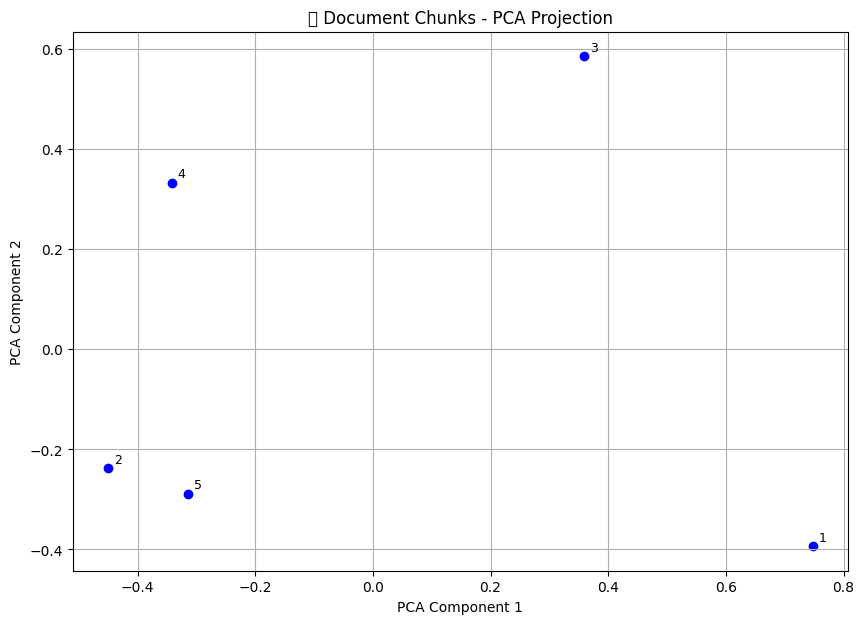

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import faiss
import numpy as np

chunks = [
    "অনুপমের ভাষায় সুপুরুষ শম্ভুনাথ।",
    "কল্যাণীর প্রকৃত বয়স ছিল ১৫ বছর।",
    "অনুপম মামাকে তার ভাগ্যদেবতা বলে মনে করে।",
    "মামা ছিলেন অত্যন্ত যত্নবান ও দায়িত্বশীল।",
    "কবিতাটি বাস্তব জীবন থেকে অনুপ্রাণিত।"
]


model = SentenceTransformer('sentence-transformers/LaBSE')

embeddings = model.encode(chunks)
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
for i, text in enumerate(chunks):
    x, y = reduced[i]
    plt.scatter(x, y, color='blue')
    plt.text(x + 0.01, y + 0.01, f"{i+1}", fontsize=9)
plt.title("📌 Document Chunks - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

In [ ]:
!pip install langchain openai langchain-community
!pip install -U langchain langchain-community langchain-openai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 26.6 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.71
    Uninstalling langchain-core-0.3.71:
      Successfully uninstalled langchain-core-0.3.71
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.8
    Uninstalling langchain-text-splitters-0.3.8:
      Successfully uninstalled langchain-text-splitters-0.3.8
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.26
    Uninstalling langchain-0.3.26:
      Successfully uninstalled langchain-0.3.26


In [ ]:

from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI

embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/LaBSE")

db = FAISS.load_local("bangla_knowledge_base", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever(search_kwargs={"k": 10})  # Use top-10 most relevant chunks

llm = ChatOpenAI(temperature=0, openai_api_key="your-openai-api-key")  # Replace with your key

memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

rag_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    verbose=True  # Enable to see what's happening
)

while True:
    user_input = input("🧑‍💬 You: ")
    if user_input.lower() in ["exit", "quit"]:
        break
    response = rag_chain({"question": user_input})
    print(f"🤖 RAG Answer: {response['answer']}")


/tmp/ipython-input-16-1911470094.py:17: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0, openai_api_key="your-openai-api-key")  # Replace with your key


🧑‍💬 You: অনুপমের বন্ধুর নাম কী?


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
অনুপমের বন্ধুর নাম কী?
ক সতীশ খ জ্যোতিষ গ হরিশ ঘ মণীষ ১৬।
মেয়ের চেয়ে মেয়ের বাপের খবরটাই কার কাছে গুরুতর?
ক হরিশের খ অনুপমের গ মামার ঘ ঘটকের ১৭।
অনুপমের শিক্ষাগত যোগ্যতা কি?
ক বিএ পাশ খ এমএ পাশ গ বিএসসি পাশ ঘ এমএসসি পাশ ১৮।
মেয়ে যদি বলো তবে উক্তিটি কার?

অপরিচিতা গল্পে অনুপমের বন্ধু কে?
ঢা বি ০ ২০১৬ ১৭ ক বিনুদা খ কল্যাণী গ হরিশ ঘ শস্তুনাথ উত্তর গ ২৫।
মাকাল ফল বাগধারাটি দিয়ে বোঝায় ঢা বি অধিভুক্ত ৭ কলেজ মানবিক ক উচ্ছিষ্ট বন্ধু খ নির্দিষ্ট খতুভিত্তিক ফল গ বিশেষ অর্থে গুণহীন ঘ কদাকার বস্ত উত্তর গ ২৬।
অপরিচিতা গল্পটি প্রথম প্রকাশ পায় কোন পত্রিকায়?

তোমার নাম কী?
কল্যাণী কে জিজ্ঞাসা করল?
ক অনুপম খ অনুপমের মা গ জেনারেল ঘ স্টেশন মাস্টার ৬৬।
আমার পিতা এক কালে গরিব ছিলেন ক

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: your-ope*******-key. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-proj-"


In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# ✅ Load FAISS DB (Long-Term Memory)
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/LaBSE")
vectorstore = FAISS.load_local("bangla_knowledge_base", embedding_model, allow_dangerous_deserialization=True)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# ✅ Load OpenAI model or any Chat LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.2)

# ✅ Short-Term Memory Buffer
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)


In [ ]:

rag_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=True
)


In [ ]:
chat_history = []

questions = [
    "অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?",
    "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?",
    "বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?"
]

# Loop through questions to simulate a session
for i, question in enumerate(questions, 1):
    response = rag_chain({"question": question, "chat_history": chat_history})
    print(f"\n🔹 User Question {i}: {question}")
    print(f"✅ Answer: {response['answer']}")

    # Add to short-term memory
    chat_history.append((question, response["answer"]))


AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: sk-proj-. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}